In [1]:
# Imports
from sklearn.cluster import KMeans
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.model_selection import cross_val_score
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [2]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')
datasets = [train_data, test_data]
all_data = pd.concat(datasets)

In [3]:
def kmeans_chart(prop, size = 0):
    krange = range(1,size if size > 0 else train_data[prop].value_counts().size)
    inertias = []
    for i in krange:
        kmeans = KMeans(n_clusters=i, random_state=0).fit(train_data[prop].values.reshape(train_data[prop].size,1))
        inertias.append(kmeans.inertia_)

    plt.plot(krange, inertias)
    plt.title(prop)
    plt.xlabel('cluster')
    plt.ylabel('inertia')
def bar_chart(feature):
    survived = train_data[train_data['Survived']==1][feature].value_counts()
    dead = train_data[train_data['Survived']==0][feature].value_counts()
    df = pd.DataFrame([survived,dead])
    df.index = ['Survived','Dead']
    df.plot(kind='bar',stacked=True, figsize=(10,5))
    
def scatter_chart(feature):
    survived = train_data[train_data['Survived']==1][feature]
    dead = train_data[train_data['Survived']==0][feature]
    y_survived = np.ones(survived.size)
    y_dead = np.zeros(dead.size)
    count_survived = survived.value_counts().to_dict()
    size_survived = survived.map(lambda x: count_survived[x]/survived.size*1000)
    count_dead = dead.value_counts().to_dict()
    size_dead = dead.map(lambda x: count_dead[x]/dead.size*1000)
    ax = plt.subplot(111)
#     ax.figure.figsize=[20, 20]
    ax.figure.set_figheight(20)
    ax.figure.set_figwidth(20)
#     ax.figure.colorbar()
    ax.scatter(y_survived, survived, marker='o', s=size_survived, alpha=0.3, cmap='viridis')
    ax.scatter(y_dead, dead, marker='o', c='r', s=size_dead, alpha=0.3)
    
#     plt.colorbar(ax.figure, ax=ax)
    ax.figure.show()

#     plt.scatter(y, survived, marker='o');

In [4]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
train_data.groupby('Survived')['Cabin'].value_counts()

Survived  Cabin      
0         C124           2
          C22 C26        2
          C23 C25 C27    2
          D26            2
          F G73          2
                        ..
1         E49            1
          E50            1
          E67            1
          E68            1
          F E69          1
Name: Cabin, Length: 163, dtype: int64

In [6]:
train_data['isAlone'] = train_data['Parch'] + train_data['SibSp'] > 0
train_data['isAlone'] = train_data['isAlone'].astype(int)


In [7]:
train_data['Fare'].describe()

count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64

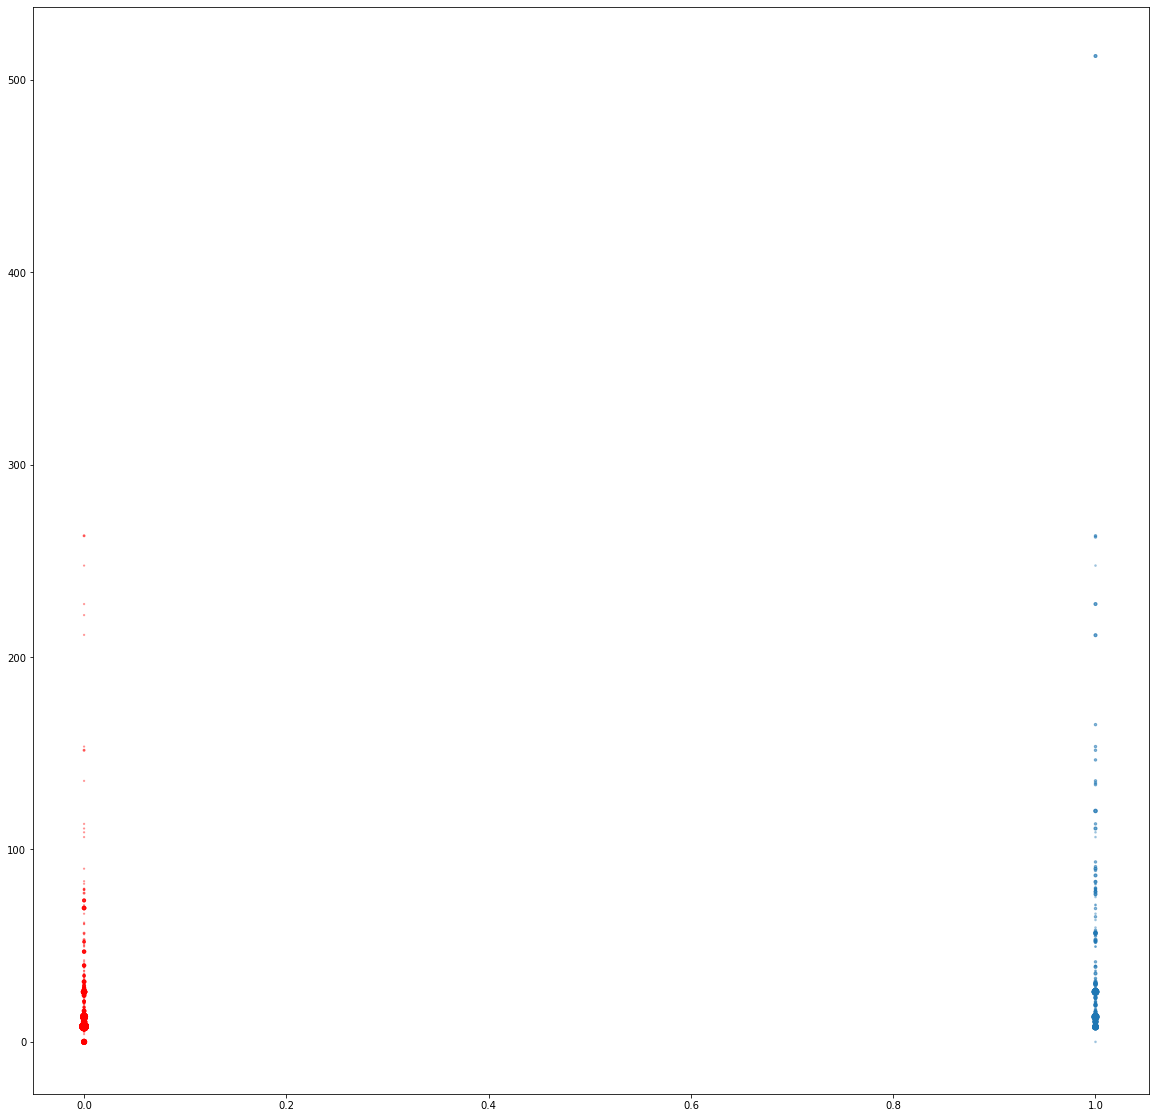

In [8]:
scatter_chart('Fare')

In [9]:
def drop_outliers(df, field_name):
    distance = 1.5 * (np.percentile(df[field_name], 75) - np.percentile(df[field_name], 25))
    df.drop(df[df[field_name] > distance + np.percentile(df[field_name], 75)].index, inplace=True)
    df.drop(df[df[field_name] < np.percentile(df[field_name], 25) - distance].index, inplace=True)
drop_outliers(train_data, 'Fare')

In [10]:
np.percentile(train_data['Fare'], 75)

26.0

In [11]:
np.percentile(train_data['Fare'], 100)

65.0

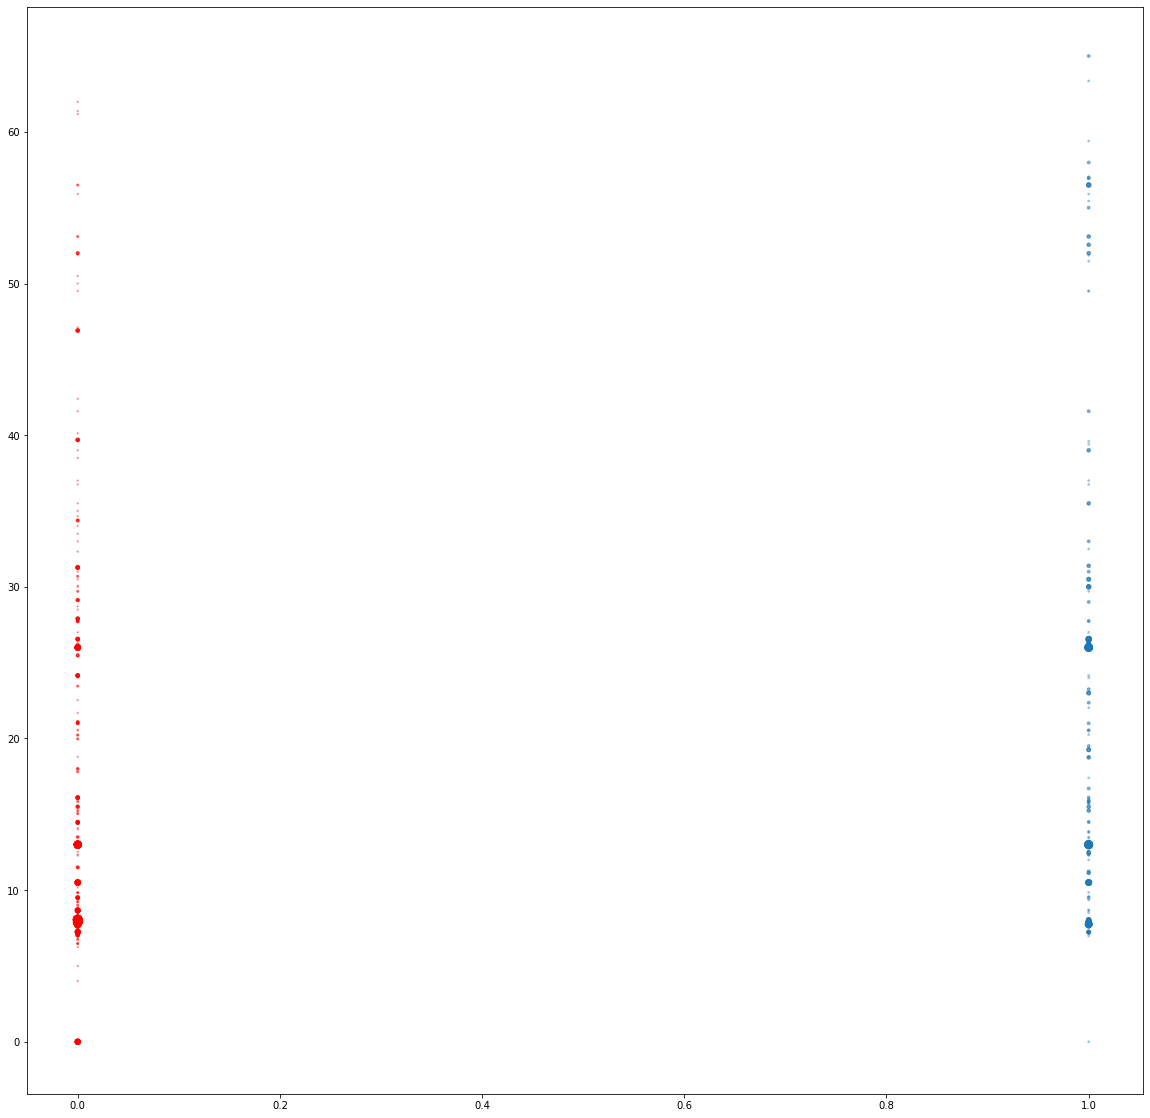

In [12]:
scatter_chart('Fare')

Text(0.5, 1, 'Correlations')

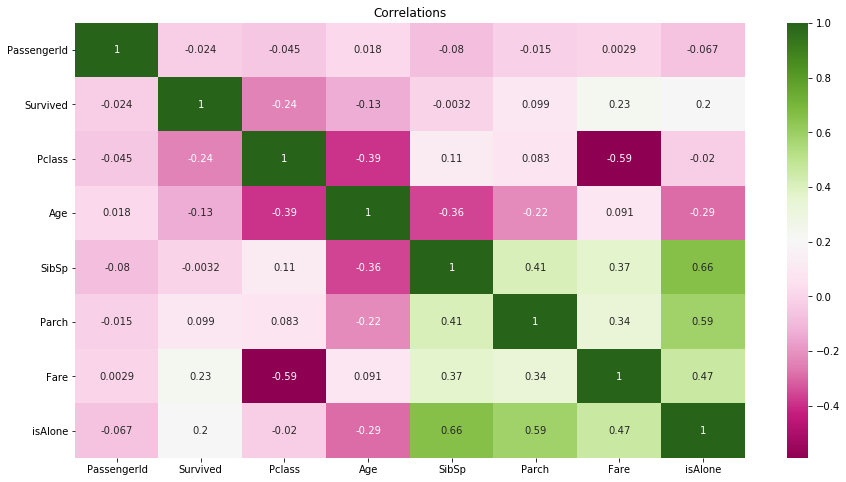

In [13]:
plt.subplots(figsize=[15, 8])
sns.heatmap(train_data.corr(), annot=True, cmap='PiYG')
plt.title('Correlations')

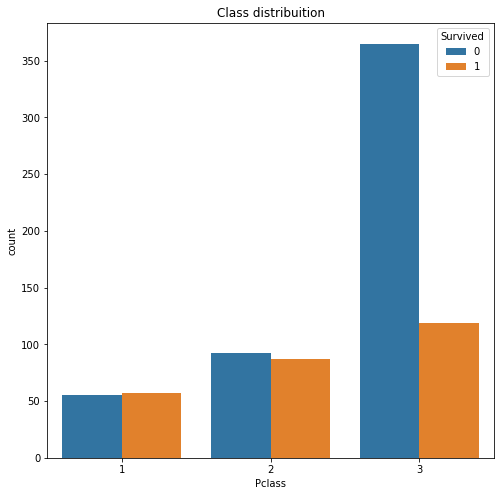

In [14]:
plt.subplots(figsize = (8,8))
ax = sns.countplot(x='Pclass', hue='Survived', data=train_data)
plt.title('Class distribuition')
leg = ax.get_legend()
leg.set_title('Survived')
legs = leg.texts
legs[0] = 'No'
legs[1] = 'Yes'

Text(0.5, 0, 'Fare')

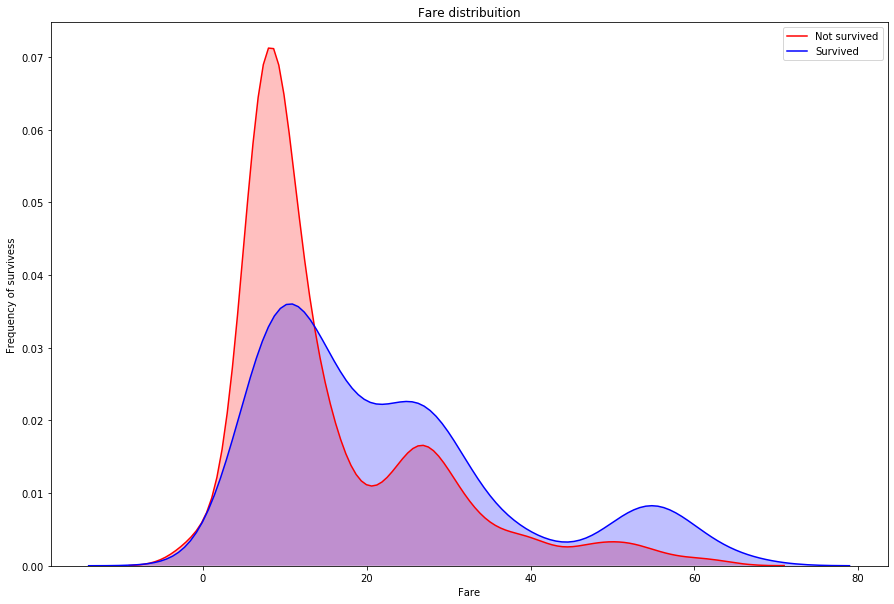

In [15]:
plt.subplots(figsize = (15,10))
ax = sns.kdeplot(train_data.loc[(train_data['Survived'] == 0), 'Fare'], color = 'r', shade=True, label = 'Not survived')
ax = sns.kdeplot(train_data.loc[(train_data['Survived'] == 1), 'Fare'], color = 'b', shade=True, label = 'Survived')
plt.title('Fare distribuition')
plt.ylabel('Frequency of survivess')
plt.xlabel('Fare')

In [16]:
def fare_outliers(row):
    distance = 1.5 * (np.percentile(train_data['Fare'], 85) - np.percentile(train_data['Fare'], 15))
    if(row['Fare'] > distance + np.percentile(train_data['Fare'], 85)):
        row['Fare'] = distance + np.percentile(train_data['Fare'], 85)
    elif(row['Fare'] < np.percentile(train_data['Fare'], 15) - distance):
        row['Fare'] = np.percentile(train_data['Fare'], 15) - distance
    return row

train_data = train_data.apply(fare_outliers, axis=1)


Text(0.5, 0, 'Fare')

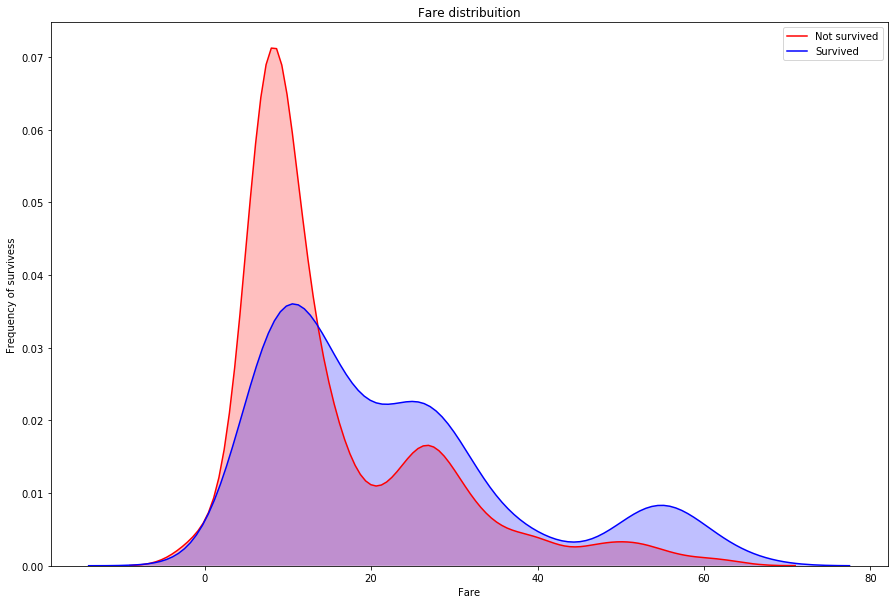

In [17]:
plt.subplots(figsize = (15,10))
ax = sns.kdeplot(train_data.loc[(train_data['Survived'] == 0), 'Fare'], color = 'r', shade=True, label = 'Not survived')
ax = sns.kdeplot(train_data.loc[(train_data['Survived'] == 1), 'Fare'], color = 'b', shade=True, label = 'Survived')
plt.title('Fare distribuition')
plt.ylabel('Frequency of survivess')
plt.xlabel('Fare')

RuntimeError: Selected KDE bandwidth is 0. Cannot estimate density.

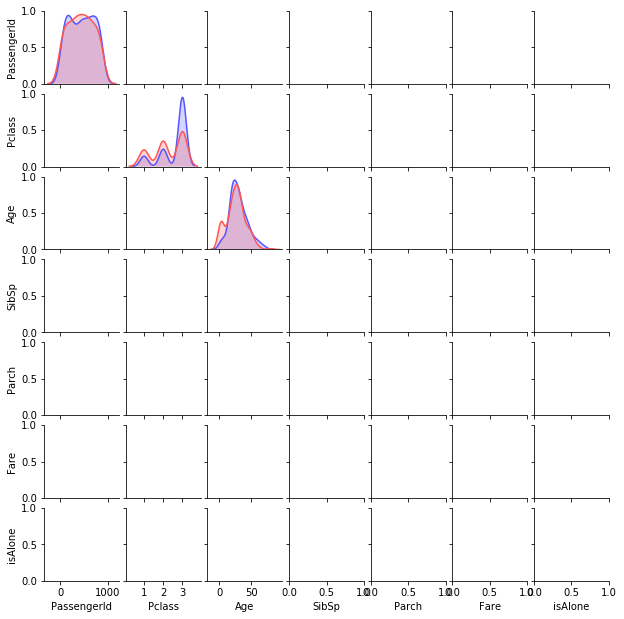

In [18]:
g = sns.pairplot(data=train_data, hue='Survived', palette = 'seismic',
                 height=1.2,diag_kind = 'kde',diag_kws=dict(shade=True),plot_kws=dict(s=10) )
g.set(xticklabels=[])

In [ ]:
plt.subplots(figsize = (8,8))
ax = sns.countplot(x='isAlone', hue='Survived', data=train_data)
plt.title('Class distribuition')
leg = ax.get_legend()
leg.set_title('Survived')
legs = leg.texts
legs[0] = 'No'
legs[1] = 'Yes'